In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46675")
client

<Client: 'tcp://127.0.0.1:46675' processes=4 threads=16, memory=58.88 GiB>

# Import

In [3]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

In [8]:
# import importlib
# importlib.reload(xrft)

# Plotting params

In [9]:
#%matplotlib widget
%matplotlib inline

In [10]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [11]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [12]:
data=[dict() for i in range(6)]

In [13]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

## eNATL60

In [14]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [15]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [16]:
nb_of_time_chunks = 4

In [17]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 2.59 s, sys: 457 ms, total: 3.04 s
Wall time: 1min 29s


## eORCA025

In [18]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

In [19]:
data[i]['LR']

<xarray.Dataset>
Dimensions:               (time_counter: 56, x: 41, y: 56)
Coordinates:
    lat                   (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    lon                   (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-08-01T00:30:00 ....
    e1t                   (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
    e2t                   (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
  * x                     (x) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39 40
  * y                     (y) int64 0 1 2 3 4 5 6 7 ... 48 49 50 51 52 53 54 55
    tmask                 (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
Data variables:
    time_centered_bounds  (time_counter, y, x) datetime64[ns] dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    time_counter_bounds   (time_counter, y, x) datetime64[ns] dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sosstsst              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sosaline              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    gradx_temp            (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grady_temp            (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    gradx_sal             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grady_sal             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grad_temp             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grad_sal              (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
Attributes:
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    uuid:              52d391e0-7850-4a5d-b56c-b43fca3a215f
    start_date:        19580101
    output_frequency:  1h
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.S
    history:           Mon Aug  9 06:33:45 2021: ncrcat eORCA025.L75-IMHOTEP....
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....

## Plot snapshots

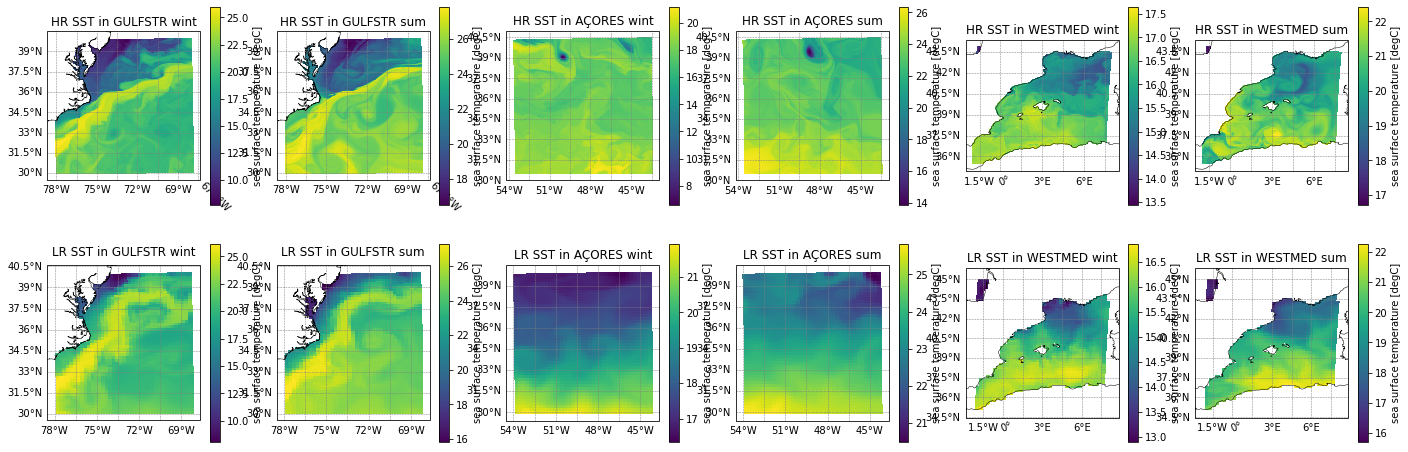

In [20]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,8), subplot_kw={'projection': ccrs.PlateCarree()})
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

In [21]:
# fig, axis = plt.subplots(ncols=2, nrows=len(data), figsize=(5*len(data),8), subplot_kw={'projection': ccrs.PlateCarree()})
# for row in range(len(data)) :
#     for col, dataSetKey in enumerate(['HR', 'LR']) :
#         data[row][dataSetKey].isel(time_counter=-1).sosaline[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
#         axis[row,col].set(title=dataSetKey + ' surafce salinity in ' + data[row]['label'])

# for ax in axis.flatten() :
#     ax.coastlines(color='k', lw=0.5)
#     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
#     gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [22]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2

CPU times: user 1.73 s, sys: 1.04 s, total: 2.77 s
Wall time: 5.72 s


# Filters

## Routines

In [23]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binariwe and erode the mask (to remove isolated pixels)
#     threshold = 0.9
#     new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
#     result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
#     # apply new mask to data
#     result = result.where(result.tmask>0)
    return result

In [24]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [25]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Coarse 15'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 15 + Coarse 15'}),
          dict({'filter_coef' : 22.5, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 22.5 + Coarse 15'}),
          dict({'filter_coef' : 30, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 30 + Coarse 15'})]

In [26]:
%%time
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    for ifilter, curr_filter in enumerate(filters) :
        data[i]['HR_Filtered'].append(apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}))

CPU times: user 6min 53s, sys: 1min 38s, total: 8min 31s
Wall time: 13min 13s


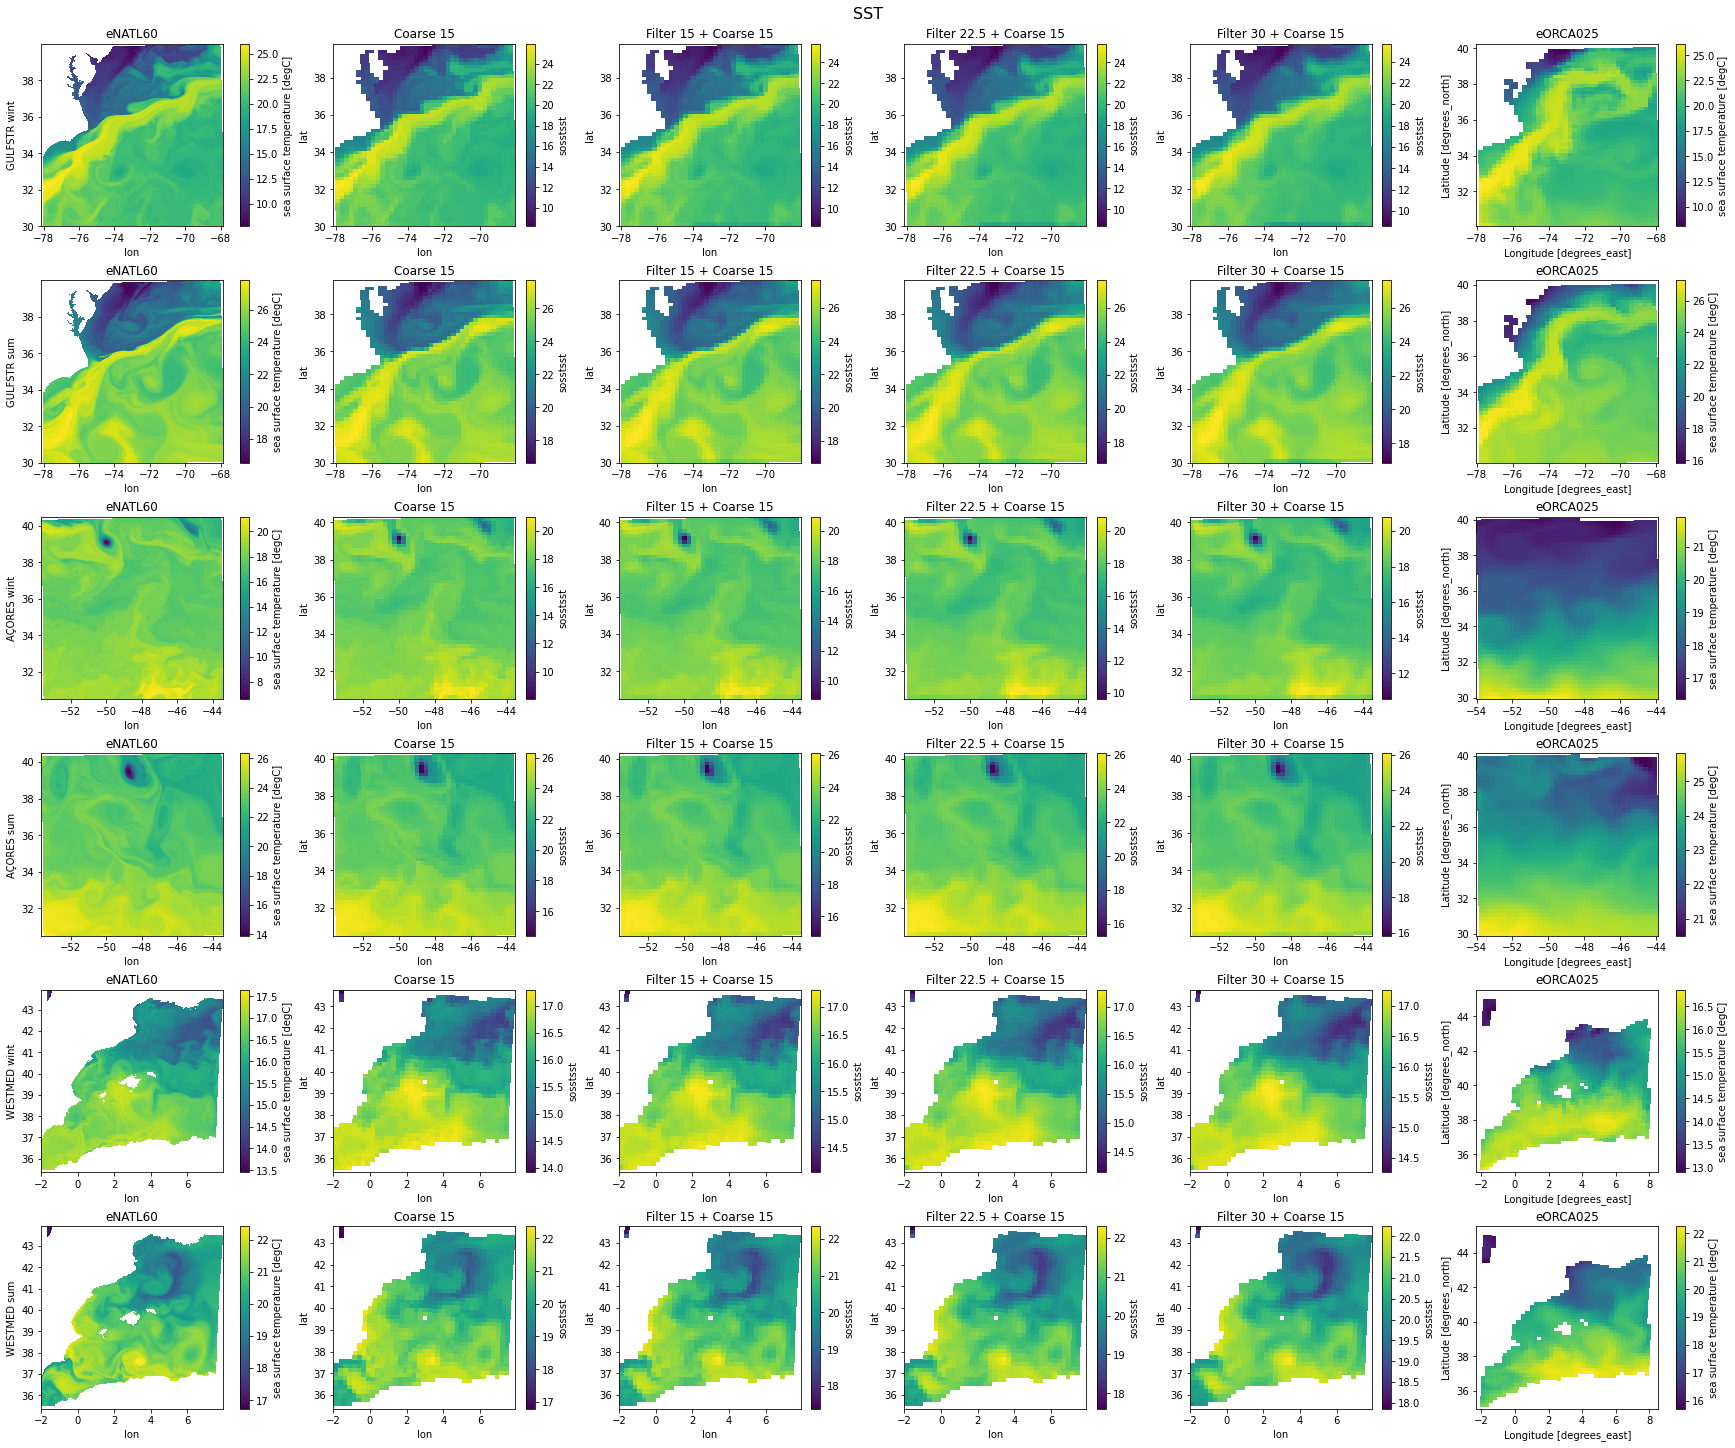

In [27]:
fig, axis = plt.subplots(ncols=6, nrows=6, figsize=(24,20), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Histograms

## General routines

In [28]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [29]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [30]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [31]:
nb_of_bins = 150

In [32]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## Histograms of spatial grads

### Compute gradients

In [33]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [34]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [35]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds['gradx_temp'] = gradx(ds['CT'], ds['e1t'])
        ds['grady_temp'] = grady(ds['CT'], ds['e2t'])
        ds['gradx_sal'] = gradx(ds['sosaline'], ds['e1t'])
        ds['grady_sal'] = grady(ds['sosaline'], ds['e2t'])
#         ds['grad_temp_sqr'] = (ds['gradx_temp']**2 + ds['grady_temp']**2).compute()
#         ds['grad_sal_sqr'] = (ds['gradx_sal']**2 + ds['grady_sal']**2).compute()
#         ds['grad_temp'] = np.sqrt(ds['grad_temp_sqr'])
#         ds['grad_sal'] = np.sqrt(ds['grad_sal_sqr'])
#         # ds['alpha_nablaT'] = (ds['alpha']*ds['grad_temp']).compute()
#         # ds['beta_nablaS'] = (ds['beta']*ds['grad_sal']).compute()
#         # ds['spicyness'] = np.sqrt((ds['alpha']*ds['gradx_temp']+ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']+ds['beta']*ds['grady_sal'])**2)
#         # ds['buoyancy'] = np.sqrt((ds['alpha']*ds['gradx_temp']-ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']-ds['beta']*ds['grady_sal'])**2)
#         ds['temp_second_deriv'] = np.abs((ds['rho_ct_ct']*ds['grad_temp_sqr']).compute())
#         # ds['mixed_second_deriv'] = (ds['rho_sa_ct']*ds['grad_temp']*ds['grad_sal']).compute()
#         ds['sal_second_deriv'] = np.abs((ds['rho_sa_sa']*ds['grad_sal_sqr']).compute())
#         # ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']
        ds['diff_temp_sqr'] = (diffx(ds['CT'])**2 + diffy(ds['CT'])**2).compute()
        ds['diff_sal_sqr'] = (diffx(ds['sosaline'])**2 + diffy(ds['sosaline'])**2).compute()
        ds['temp_pred'] = np.abs(ds['rho_ct_ct']*ds['diff_temp_sqr'])
        ds['sal_pred'] = np.abs(ds['rho_sa_sa']*ds['diff_sal_sqr'])

CPU times: user 1min 9s, sys: 1.77 s, total: 1min 11s
Wall time: 1min 24s


### Temperature

In [36]:
%%time
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp'
y = 'grady_temp'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.82 s, sys: 191 ms, total: 3.01 s
Wall time: 12.4 s


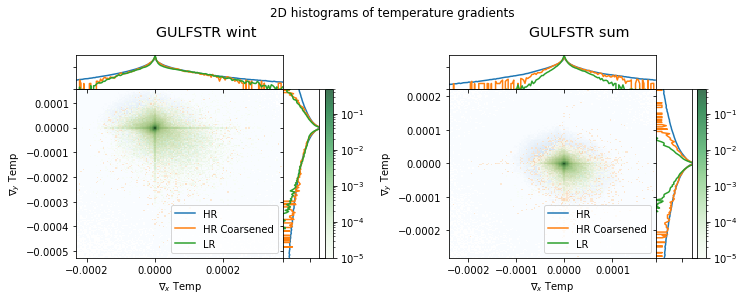

In [37]:
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp_bin'
y = 'grady_temp_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of temperature gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['HR'][name_hist]
    sel_data1 = hists[region]['HR_Filtered'][0][name_hist]
    sel_data2 = hists[region]['LR'][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Temp', ylabel=r'$\nabla_y$ Temp')
    big_ax.legend(handles=top_ax.lines, labels=['HR', 'HR Coarsened','LR'], loc='lower right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Salinity

In [38]:
%%time
name_hist = 'hist_sal_grad_2D'
x = 'gradx_sal'
y = 'grady_sal'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 4.99 s, sys: 154 ms, total: 5.14 s
Wall time: 25.3 s


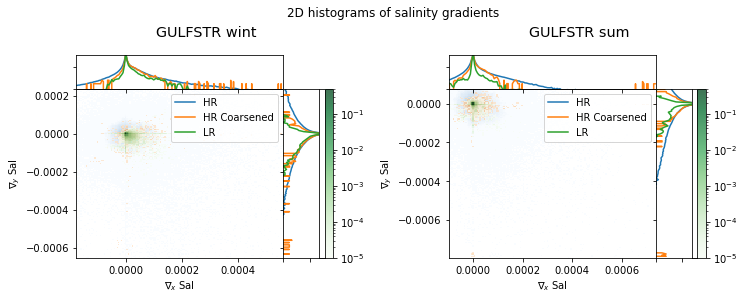

In [39]:
name_hist = 'hist_sal_grad_2D'
x = 'gradx_sal_bin'
y = 'grady_sal_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of salinity gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['HR'][name_hist]
    sel_data1 = hists[region]['HR_Filtered'][0][name_hist]
    sel_data2 = hists[region]['LR'][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Sal', ylabel=r'$\nabla_y$ Sal')
    big_ax.legend(handles=top_ax.lines, labels=['HR', 'HR Coarsened','LR'], loc='upper right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Joint temperature and salinity

In [54]:
%%time
name_hist = 'hist_temp_sal_sqr'
# x = 'temp_second_deriv'
# y = 'sal_second_deriv'
x='temp_pred'
y='sal_pred'

for i in range(len(data)) :
    # reference histogram
    ref_case = 2
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 6.65 s, sys: 695 ms, total: 7.34 s
Wall time: 19.4 s


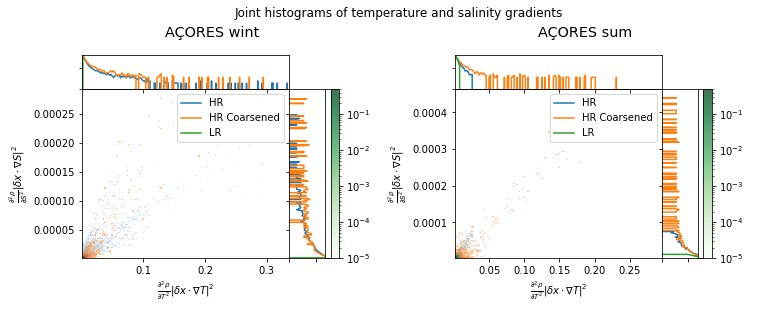

In [55]:
name_hist = 'hist_temp_sal_sqr'
x = 'temp_pred_bin'
y = 'sal_pred_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('Joint histograms of temperature and salinity gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([2,3]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['HR'][name_hist]
    sel_data1 = hists[region]['HR_Filtered'][0][name_hist]
    sel_data2 = hists[region]['LR'][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\frac{\partial^2 \rho}{\partial T^2} |\delta x \cdot \nabla T|^2$', ylabel=r'$\frac{\partial^2 \rho}{\partial S^2} |\delta x \cdot \nabla S|^2$')
    big_ax.legend(handles=top_ax.lines, labels=['HR', 'HR Coarsened','LR'], loc='upper right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Comparison between histograms (distances)

#### KL divergence

Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [44]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [45]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

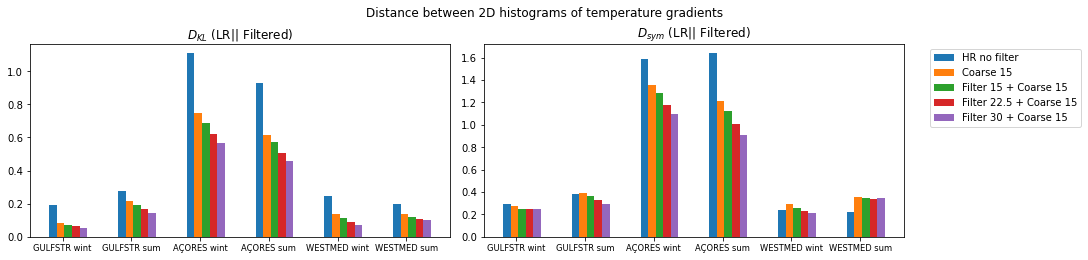

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of temperature gradients')
name_hist = 'hist_temp_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_{KL}$ ('+ ref_dataKey +'|| Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_{sym}$ ('+ ref_dataKey +'|| Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

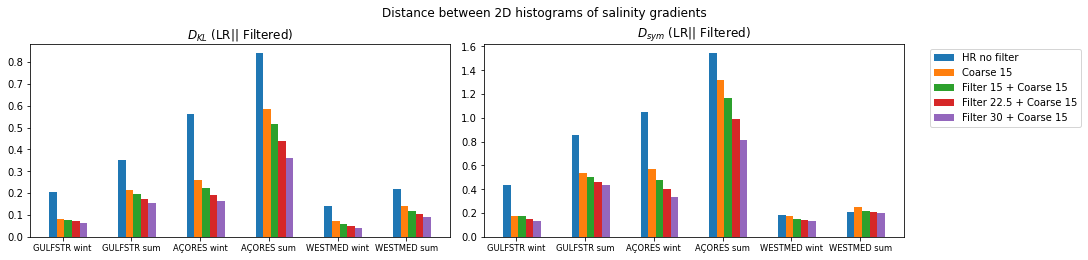

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of salinity gradients')
name_hist = 'hist_sal_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_{KL}$ ('+ ref_dataKey +'|| Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_{sym}$ ('+ ref_dataKey +'|| Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### B-distrance

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [48]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-BC(hist_P,hist_Q))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return 0.

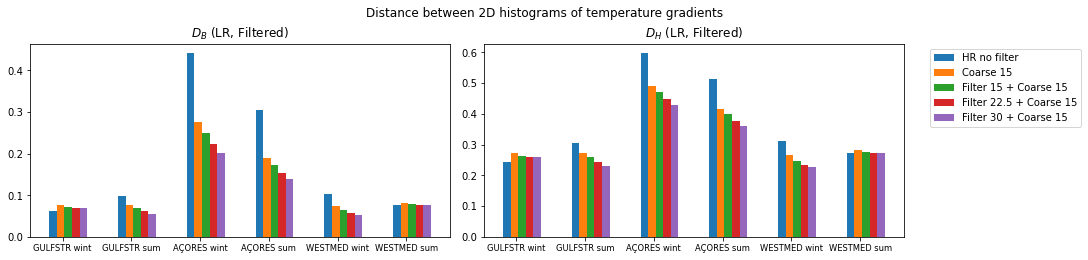

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of temperature gradients')
name_hist = 'hist_temp_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

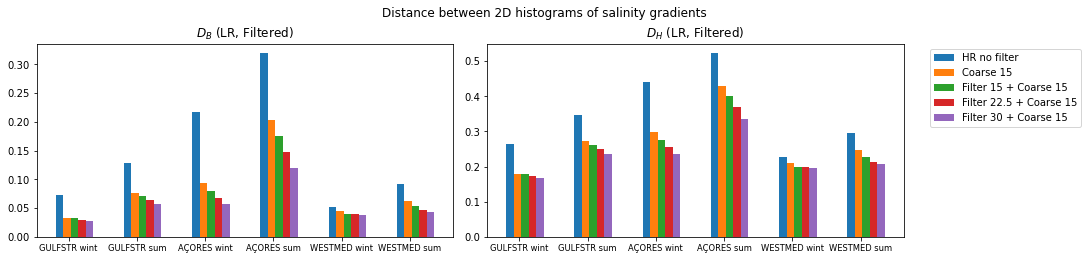

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of salinity gradients')
name_hist = 'hist_sal_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

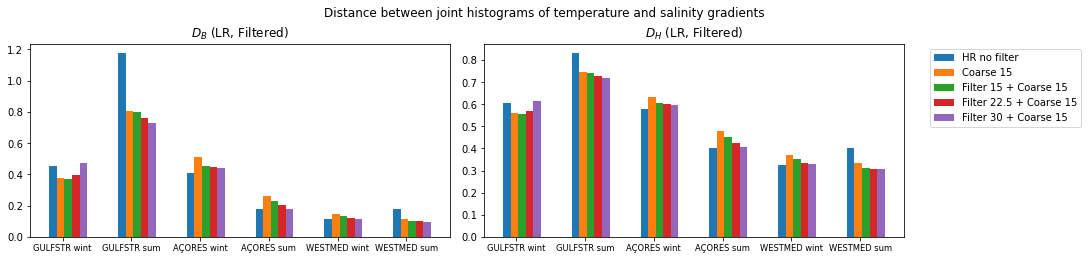

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between joint histograms of temperature and salinity gradients')
name_hist = 'hist_temp_sal_sqr'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [57]:
#data[2]['LR']['grad_sal_sqr'].isel(time_counter=0).plot()

In [58]:
#hists[2]['LR']['hist_temp_sal_sqr']

# Structure functions

In [59]:
def compute_structure_functions(dataArr, key_field) :
    N = len(dataArr['x'])
    #nb_of_shifts = N//2-1
    nb_of_shifts = 25
    vectorS1 = np.zeros(nb_of_shifts)
    vectorS2 = np.zeros(nb_of_shifts)
    vectorS3 = np.zeros(nb_of_shifts)
    distance = np.zeros(nb_of_shifts)
    for index,index_shift in enumerate(range(0,nb_of_shifts)) :
        # take a slice with removed last 'index_shift' numbers 
        cut=slice(1,N-index_shift)
        shiftedArr_x = dataArr[key_field].roll(x=-index_shift,roll_coords=False)
        shiftedArr_y = dataArr[key_field].roll(y=-index_shift,roll_coords=False)
        difference_x = dataArr[key_field][cut] - shiftedArr_x[cut]
        difference_y = dataArr[key_field][cut] - shiftedArr_y[cut]
        vectorS1[index] = 0.5*(difference_x+difference_y).mean().values
        vectorS2[index] = (0.5*(difference_x**2+difference_y**2)).mean().values
        vectorS3[index] = 0.5*(difference_x**3+difference_y**3).mean().values
        distance[index] = dataArr.isel(x=slice(0,index_shift)).e1t.sum(dim='x').mean(dim='y').values
    stucture_functions_dataset = xr.Dataset(data_vars={'S1' : xr.DataArray(vectorS1, dims=["shift"]),\
                                             'S2' : xr.DataArray(vectorS2, dims=["shift"]),\
                                             'S3' : xr.DataArray(vectorS3, dims=["shift"])
                                            }, \
                                            coords={'shift' : np.arange(0,nb_of_shifts),\
                                                   'shift_distance' : ('shift', distance/1000)})
    return stucture_functions_dataset

In [60]:
# initialize data structure for storing histograms
str_fun=[dict() for i in range(len(data))]
for i in range(len(data)) :
    str_fun[i]['HR_Filtered'] = [dict({'label' : filters[i]['label']}) for i in range(len(filters))] 
    str_fun[i]['HR'] = dict({'label' : 'eNATL60'})
    str_fun[i]['LR'] = dict({'label' : 'eORCA025'})

In [61]:
%%time 
for i in range(len(data)) :
    str_fun[i]['LR']['temp_str_fun'] = compute_structure_functions(data[i]['LR'],'CT')
    for ifilter in range(len(filters)) :
        str_fun[i]['HR_Filtered'][ifilter]['temp_str_fun'] = compute_structure_functions(data[i]['HR_Filtered'][ifilter],'CT')

CPU times: user 1min 10s, sys: 1.85 s, total: 1min 12s
Wall time: 3min 14s


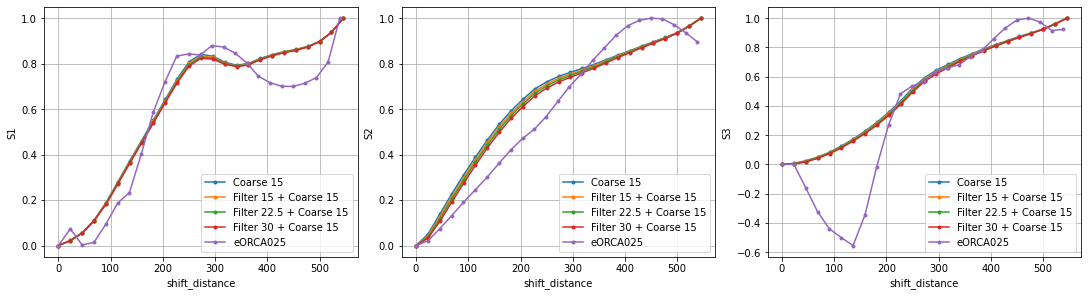

In [62]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
i=0
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for ds in [str_fun[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [str_fun[i]['LR']] :
        data_to_plot = ds['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label=ds['label'], marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

# Regridding onto HR grid

In [63]:
#regrid_method = "nearest_s2d"
regrid_method = "bilinear"

In [64]:
for i in range(len(data)) :
    data[i]['Regrid_HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 

In [65]:
%%time
%%capture --no-display
for i in range(len(data)) :
    out_grid = data[i]['HR'].drop(['time_centered', 'depth', 'time_counter', 'e1t', 'e2t', 'e1f', 'e2f', 'e1v', 'e2v', 'e1u', 'e2u', 'nav_lat', 'nav_lon', 'tmask', 'sosstsst', 'sosaline'])
    regridder = xe.Regridder(data[i]['LR'], out_grid, regrid_method, unmapped_to_nan=True)
    data[i]['Regrid_LR'] = regridder(data[i]['LR'].drop(['sossheig', 'gradx_temp', 'grady_temp', 'gradx_sal', 'grady_sal', 'grad_temp', 'grad_sal']))
    for ifilter in range(len(filters)) :
        regridder = xe.Regridder(data[i]['HR_Filtered'][ifilter], out_grid, regrid_method, unmapped_to_nan=True)
        data[i]['Regrid_HR_Filtered'][ifilter] = regridder(data[i]['HR_Filtered'][ifilter])

CPU times: user 4min 56s, sys: 20.5 s, total: 5min 17s
Wall time: 5min 18s


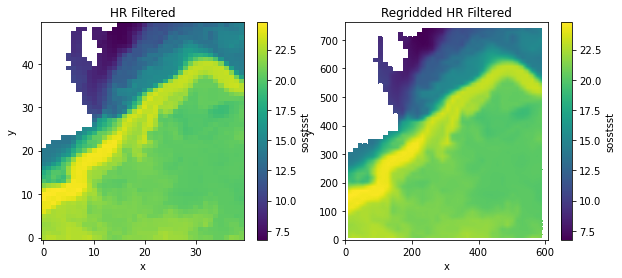

In [66]:
region=0
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
data[region]['HR_Filtered'][0].isel(time_counter=0).sosstsst.plot(ax=axis[0])
data[region]['Regrid_HR_Filtered'][0].isel(time_counter=0).sosstsst.plot(ax=axis[1])
axis[0].set(title='HR Filtered')
axis[1].set(title='Regridded HR Filtered')
plt.show()

# Spectra

In [67]:
# without interpolation
def prepare_data_for_spec(data, variable) :
    res = data[variable].dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    if ("e1t" in data) :
        delta_x = res['e1t'].mean(skipna=True).values
        delta_y = res['e2t'].mean(skipna=True).values
    else :
        delta_x = gsw.distance(data.lon,data.lat).mean(skipna=True)
        delta_y = gsw.distance(data.lon,data.lat).mean(skipna=True)
        
    res.coords['x'] = res.coords['x']*delta_x
    res.coords['y'] = res.coords['y']*delta_y 

    # fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    res = res.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")

    res = res.drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'e1t', 'e2t'], errors='ignore')
    return res

## Isotropic power spectra

In [68]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    #prepared_data = uniform_grid_interpolation(data.drop(['tmask'], errors='ignore'), variable) # with interpolation on a uniform grid
    prepared_data = prepare_data_for_spec(data.drop(['tmask'], errors='ignore'), variable) # with interpolation on a uniform grid
    isotropic_power_spec = xrft.isotropic_power_spectrum(prepared_data, dim=['x','y'], detrend='linear', nfactor=binning_factor, truncate=True)
    return isotropic_power_spec.rename('Spatial_spectrum')

In [69]:
# initialize data structure for storing histograms
spec=[dict() for i in range(len(data))]
for i in range(len(data)) :
    spec[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    spec[i]['HR'] = dict({'label' : 'eNATL60'})
    spec[i]['LR'] = dict({'label' : 'eORCA025'})
    spec[i]['Regrid_LR'] = dict({'label' : 'Regrid eORCA025'})
    spec[i]['Regrid_HR_Filtered'] = [dict({'label' : 'Regrid' + filters[ifilter]['label']}) for ifilter in range(len(filters))] 

In [70]:
%%time 
for quantity in ['sosstsst', 'sosaline'] :
    for i in range(len(data)) :
        for key_dict in ['LR', 'HR', 'Regrid_LR'] :
            spec[i][key_dict][quantity + '_spec'] = (wrapper_xrtf_isotropic_PS(data[i][key_dict], quantity, binning_factor=4)).mean(dim='time_counter').compute()
        for ifilter in range(len(filters)) :
            spec[i]['HR_Filtered'][ifilter][quantity + '_spec'] = (wrapper_xrtf_isotropic_PS(data[i]['HR_Filtered'][ifilter], quantity, binning_factor=4)).mean(dim='time_counter').compute()
            spec[i]['Regrid_HR_Filtered'][ifilter][quantity + '_spec'] = (wrapper_xrtf_isotropic_PS(data[i]['Regrid_HR_Filtered'][ifilter], quantity, binning_factor=4)).mean(dim='time_counter').compute()

CPU times: user 1min 52s, sys: 9.27 s, total: 2min 1s
Wall time: 11min 27s


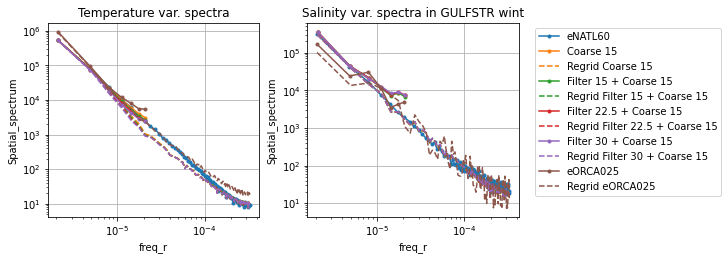

In [71]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10,3.5))
region=0
for i, quantity in enumerate(['sosstsst', 'sosaline']) :
    spec[region]['HR'][quantity + '_spec'].plot(ax=ax[i], label='eNATL60', ls='-', marker='.', color=line_colors[0])
    for ifilter in range(len(filters)) :
        spec[region]['HR_Filtered'][ifilter][quantity + '_spec'].plot(ax=ax[i], label=filters[ifilter]['label'], ls='-', marker='.', color=line_colors[ifilter+1])
        spec[region]['Regrid_HR_Filtered'][ifilter][quantity + '_spec'].plot(ax=ax[i], label='Regrid '+filters[ifilter]['label'], ls='--', color=line_colors[ifilter+1])
    spec[region]['LR'][quantity + '_spec'].plot(ax=ax[i], label='eORCA025', ls='-', marker='.', color=line_colors[5])
    spec[region]['Regrid_LR'][quantity + '_spec'].plot(ax=ax[i], label='Regrid eORCA025', ls='--', color=line_colors[5])
#[spec[region]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + 
#ax[0].plot(spec[region]['HR']['sosstsst_spec']['wavenumber'], 5e-10*spec[region]['HR']['sosstsst_spec']['wavenumber']**(-7/3), ls='--', color='k', label=r'$k^{-3}$')
#ax[0].plot(spec[region]['HR']['sosstsst_spec']['wavenumber'], 5e-10*spec[region]['HR']['sosstsst_spec']['wavenumber']**(-2), ls='-.', color='k', label=r'$k^{-2}$')
for axis in ax :
    axis.set(yscale='log', xscale='log'); axis.grid(True)
ax[0].set(title='Temperature var. spectra')
ax[1].set(title='Salinity var. spectra in '+data[region]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()